In [124]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

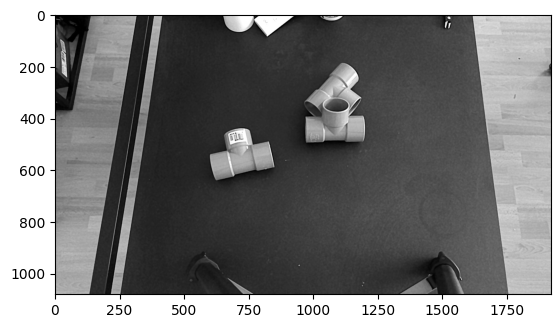

In [125]:
img_orig = cv2.imread("2025-02-20_14-16-29.jpg")
assert img_orig is not None, "File could not be read"

gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap="gray")

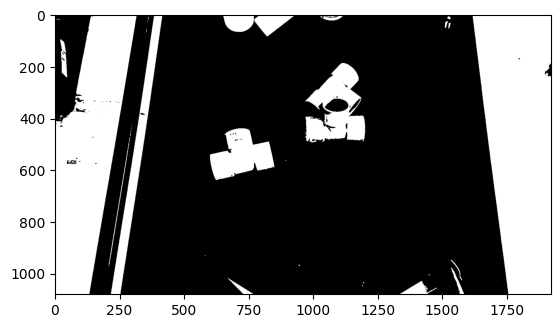

In [126]:
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(thresh, cmap='gray')

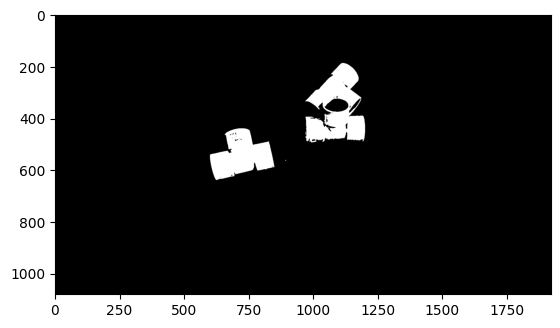

In [127]:
## Define ROI bounding box (image coordinates), everything outside = background
x_min, y_min = 500, 100
x_max, y_max = 1500, 800

thresh_masked = np.zeros_like(thresh)

## Create mask where everything inside bounding box = ROI
thresh_masked[y_min:y_max, x_min:x_max] = thresh[y_min:y_max, x_min:x_max]

masked_image = thresh_masked

plt.imshow(masked_image, cmap="gray")

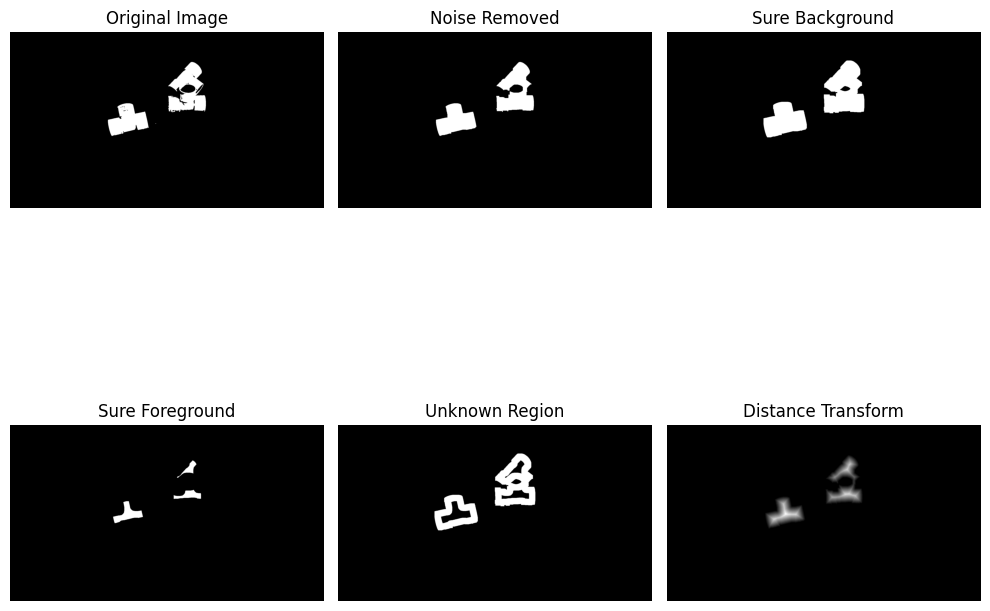

In [128]:
## Remove noise
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(masked_image,cv2.MORPH_OPEN,kernel, iterations = 2)

## Close holes in objects (morphological closing)
kernel = np.ones((7,7),np.uint8)
opening = cv2.morphologyEx(opening,cv2.MORPH_CLOSE,kernel, iterations = 3)

## Region near center of objects are sure foreground, region far away from center is background

## Sure background (black region shows sure background)
# Dilate the objects --> everything black is sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

## Sure foreground (white shows sure foreground)
# Eroding? --> doesn't work if objects are touching each other
# Apply distance transform and proper threshold
# Returns gradient image with brighter pixels near center of objects
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
# Pixels above threshold are designated as part of sure foreground
ret, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)

## Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

## Plot results
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
images = [masked_image, opening, sure_bg, sure_fg, unknown, dist_transform]
titles = ["Original Image", "Noise Removed", "Sure Background", "Sure Foreground", "Unknown Region", "Distance Transform"]

for ax, img, title in zip(axes.flat, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

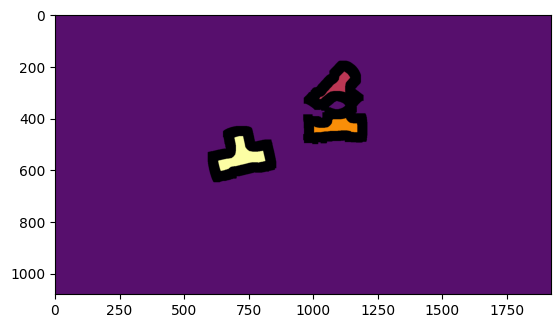

In [129]:
## Marker labelling
# All sure foreground objects seen as components with positive integer
# background + unknown = 0 (but background is not unknown actually)
ret, markers = cv2.connectedComponents(sure_fg)

## Add 1 so background is not 0
markers = markers + 1

## Mark region of unknown with zero
markers[unknown==255] = 0

# Black shows the unknown region, purple = background, others = objects
plt.imshow(markers, cmap='inferno')

(1080, 1920, 3)
(1080, 1920)


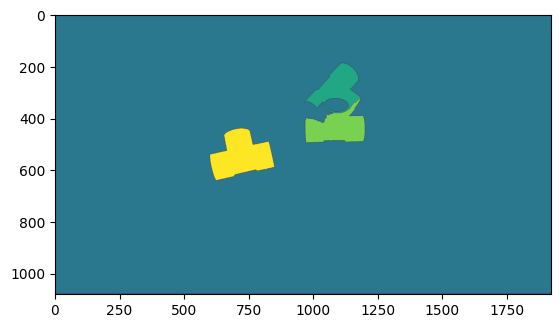

In [130]:
print(img_orig.shape)
print(markers.shape)

## Applying watershed
watershed_img = cv2.watershed(img_orig, markers)

# img[watershed_img == -1] = [255,0,0]
plt.imshow(watershed_img)
